In [11]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata

In [12]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = 6000
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = y.reshape(8569,)
print(y_ndarray.shape)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

D:\Environment\Conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569,)
(8569, 6000) (8569,)


,1,2,4,7,10,13,26,31,32,33,...,20104,20105,20108,20109,20115,20118,20121,20122,20123,20124
0,1.024218,0.0,0.0,0.0000,1.302199,0.0,0.0,0.0,0.637877,0.0,...,0.0000,0.0,0.36896,0.0,0.0000,0.0,0.637877,0.0000,0.000000,0.368960
1,0.000000,0.0,0.0,0.0000,1.351171,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.888292,0.0000,0.305824,0.000000
2,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.000000,0.0000,0.000000,0.000000
3,0.000000,0.0,0.0,0.4175,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.4175,0.0,0.00000,0.0,0.4175,0.0,0.937850,0.4175,0.000000,0.000000
4,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.509045,0.0000,0.000000,0.509045


In [13]:
from modules import network
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
class_num = len(np.unique(y_ndarray))

In [14]:
from torch.utils.data import DataLoader,random_split,TensorDataset

# y_label=nn.functional.one_hot(torch.tensor(y_ndarray-1,dtype=torch.int64),num_classes=class_num)
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray-1, dtype=torch.int64))

scTrainLength = int(len(scDataset) * 0.8)
scValidLength = len(scDataset) - scTrainLength
scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])
print(len(scTrain),len(scValid))
scTrainDataLoader = DataLoader(scTrain, shuffle=True, batch_size=args.batch_size,drop_last=True)
scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scTrainDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break



6855 1714
6000
256
256


In [15]:
from modules import mlp
network=mlp.ValidMLP(num_genes=args.num_genes)
from torchkeras import summary
summary(network,input_shape=(6000,))
network=network.to('cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       6,145,024
              ReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
             ReLU-14                   

In [16]:
from sklearn.metrics import accuracy_score
loss_device=torch.device('cuda')
loss_func = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(params=network.parameters(),lr = 0.01)

In [17]:
def train():
    global batch_idx
    running_loss = 0.0

    for batch_idx, data in enumerate(scTrainDataLoader, 1):
        inputs, target = data
        inputs=inputs.to('cuda')
        target=target.to('cuda')
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx%10==0:
             print("[step = %d] loss: %.3f " % (batch_idx, running_loss / batch_idx))
    return running_loss / batch_idx


In [18]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in scValid:
            inputs, labels = data
            inputs=inputs.to('cuda')
            labels=labels.to('cuda')
            outputs = network(inputs)
            outputs=outputs.cpu().numpy()
            predicted = np.argmax(outputs.data)
            total+=1
            correct += (predicted == labels).sum().item()
    print('Accuracy on test set: %d %%' % (100 * correct / total))
    return correct/total

In [19]:
losses=[]
accuracies=[]
for epoch in range(100):
    print(epoch)
    loss=train(epoch)
    losses.append(loss)
    acc=test()
    accuracies.append(acc)

0
[step = 10] loss: 2.618 
[step = 20] loss: 2.610 
Accuracy on test set: 26 %
1
[step = 10] loss: 2.578 
[step = 20] loss: 2.570 
Accuracy on test set: 26 %
2
[step = 10] loss: 2.535 
[step = 20] loss: 2.530 
Accuracy on test set: 26 %
3
[step = 10] loss: 2.502 
[step = 20] loss: 2.494 
Accuracy on test set: 26 %
4
[step = 10] loss: 2.462 
[step = 20] loss: 2.461 
Accuracy on test set: 26 %
5
[step = 10] loss: 2.433 
[step = 20] loss: 2.426 
Accuracy on test set: 28 %
6
[step = 10] loss: 2.394 
[step = 20] loss: 2.390 
Accuracy on test set: 28 %
7
[step = 10] loss: 2.364 
[step = 20] loss: 2.355 
Accuracy on test set: 31 %
8
[step = 10] loss: 2.326 
[step = 20] loss: 2.319 
Accuracy on test set: 32 %
9
[step = 10] loss: 2.277 
[step = 20] loss: 2.279 
Accuracy on test set: 33 %
10
[step = 10] loss: 2.231 
[step = 20] loss: 2.234 
Accuracy on test set: 31 %
11
[step = 10] loss: 2.196 
[step = 20] loss: 2.186 
Accuracy on test set: 32 %
12
[step = 10] loss: 2.138 
[step = 20] loss: 2.12

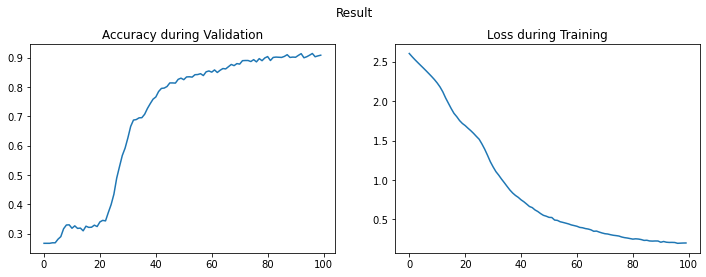

In [20]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accuracies)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()